Aim here is to perform a very simple analysis to check if the exposure regions is working correctly.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
import corner
import matplotlib.pyplot as plt
from matplotlib import rcParams

from NPTFit import nptfit # module for performing scan
from NPTFit import dnds_analysis # module for analysing the output

# 1 Exposure Region

Confirm that if we have a uniform exposure map and only a single exposure region the code can recover what we inject. As seen below it does a good job.

No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


/zfs/nrodd/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/zfs/nrodd/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


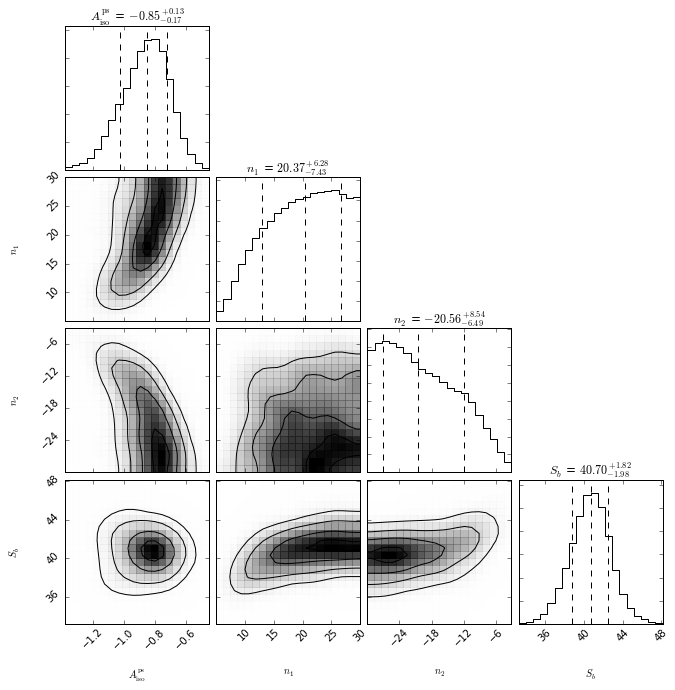

Flux fraction [16,50,84] percentiles: [  81.62620864   99.60031867  118.62100291]
Median of FFs over params: 98.8717602163


In [2]:
# Setup data and exposure
nside = 2
nps = 30
psc = 40
ner = 1
emaxval = 1.0

npix = hp.nside2npix(nside)
exposure = np.zeros(npix)
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = emaxval
data = np.zeros(npix, dtype='int')
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(psc*exposure[loc])
totaldata = np.sum(data)

#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,200]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

#print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

#print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*
                                                 np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)
                                                +1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100

# 2 Exposure Regions

Now we break the exposure region into two regions with values a factor of 2 apart, but keep nexp=1. This shouldn't work, but is just designed as a baseline to see what happens when we move away from this. As expected the code recovers a much larger Sb than is correct. Interestingly it also wants a much larger n2 than required by a delta function injection, suggesting it wants a lot of dim point sources.

86.35
No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


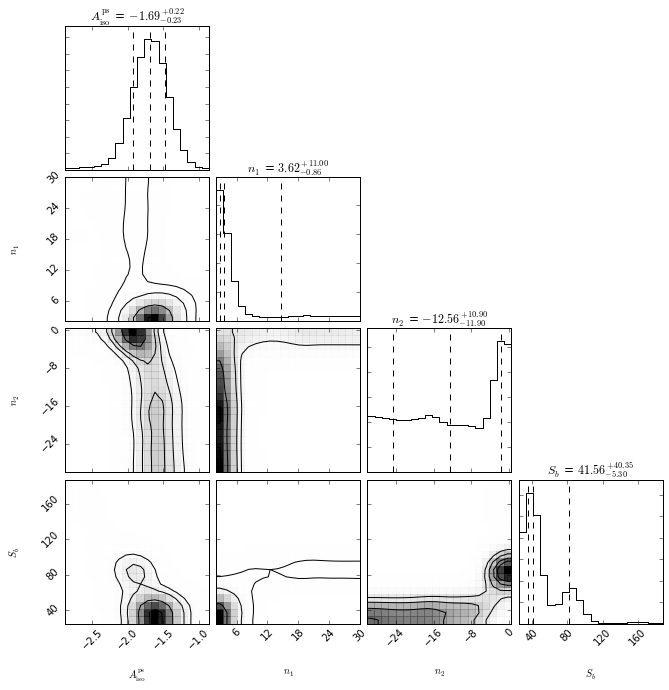

Flux fraction [16,50,84] percentiles: [  83.55648379  105.23720455  134.86081342]
Median of FFs over params: 104.647249124


In [3]:
# Setup data and exposure
nside = 2
nps = 30
psc = 40
ner = 1
emaxval = 2.0

npix = hp.nside2npix(nside)
exposure = np.zeros(npix)
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = emaxval
data = np.zeros(npix, dtype='int')
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(psc*exposure[loc])
totaldata = np.sum(data)
print np.mean(data[np.where(data != 0)])

#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,200]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

#print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

#print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*
                                                 np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)
                                                +1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100

Now we try this with 2 exposure regions (which is all there is). Critically it is not recovering Sb ~ 40, which we injected.


Note I've tested that the results below are stable if we change to npix exposure regions, increase nlive, or interestingly swap the NPTF template from 1/exp to exp or flat. This suggests there is a more fundamental bug.

No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


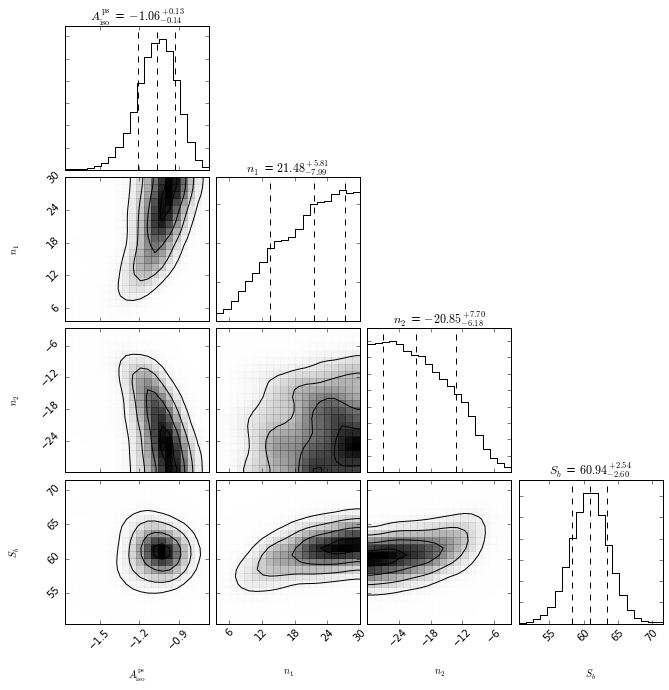

Flux fraction [16,50,84] percentiles: [  88.96801293  107.89187156  127.86846965]
Median of FFs over params: 107.301910887


In [4]:
# Setup data and exposure
ner = 2 # can take this all the way to ner = npix and get the same answer

#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,200]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500) # increasing nlive doesn't help

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

#print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

#print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*
                                                 np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)
                                                +1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100

As a hint as to what is going on, note it is recovering 60, which is near what the average flux per PS would be if we had this data map and a flat exposure map.

In [8]:
print np.sum(data[np.where(data != 0)])/30.
print np.sum(data[np.where(data != 0)]/exposure[np.where(data != 0)])/30.

57.5666666667
41.7166666667
